# Data Preparation

## Import Data

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from heatmap import heatmap, corrplot

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score as cv_score

import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
path = './data/ufc-master.csv'
ufc_0 = pd.read_csv(path)

ufc_0.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,450.0,350.0,700.0,1100.0,550.0,120.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,550.0,275.0,275.0,1400.0,600.0,185.0
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,Punch,1.0,1:20,80.0,175.0,900.0,500.0,3500.0,110.0,1100.0
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,165.0,200.0,400.0,1200.0,900.0,600.0


## Initial Data Inspection

In [3]:
ufc_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Columns: 119 entries, R_fighter to b_ko_odds
dtypes: bool(1), float64(58), int64(46), object(14)
memory usage: 4.4+ MB


In [4]:
ufc_0.loc[:,'B_Lightweight_rank'].describe()

count    87.000000
mean      8.126437
std       4.119733
min       1.000000
25%       5.000000
50%       8.000000
75%      11.500000
max      15.000000
Name: B_Lightweight_rank, dtype: float64

In [5]:
ufc_0.isnull().sum().sort_values(ascending=False).iloc[:10]

B_Women's Featherweight_rank    4896
R_Women's Featherweight_rank    4889
B_Pound-for-Pound_rank          4861
B_Women's Flyweight_rank        4852
R_Women's Flyweight_rank        4837
B_Women's Strawweight_rank      4835
B_Women's Bantamweight_rank     4818
B_Bantamweight_rank             4811
B_Lightweight_rank              4809
B_Welterweight_rank             4807
dtype: int64

In [6]:
ufc_0.isnull().sum().loc[ufc_0.isnull().sum()==0].shape

(67,)

In [7]:
ufc_0.loc[:,'Winner'].unique()

array(['Red', 'Blue'], dtype=object)

In [8]:
print(ufc_0.shape)
ufc_0.head(3)

(4896, 119)


,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,450.0,350.0,700.0,1100.0,550.0,120.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,550.0,275.0,275.0,1400.0,600.0,185.0


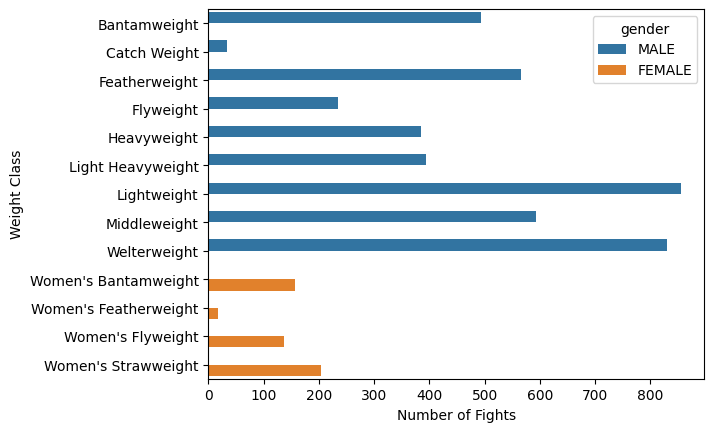

In [9]:
# Visualize # of fighters in each weight class
sns.countplot(data=ufc_0.sort_values(by='weight_class') , y = 'weight_class' , hue='gender')
plt.xlabel('Number of Fights')
plt.ylabel('Weight Class')
plt.show();

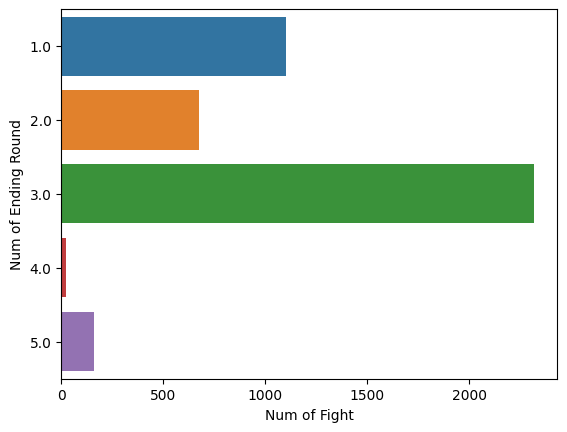

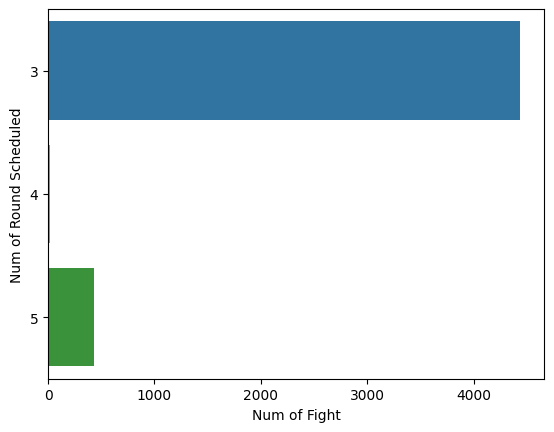

In [10]:
# Visualize the # round finished against the # round planned
sns.countplot(data=ufc_0.sort_values(by='finish_round') , y = 'finish_round')
plt.xlabel('Num of Fight')
plt.ylabel('Num of Ending Round')
plt.show()

sns.countplot(data=ufc_0.sort_values(by='no_of_rounds') , y = 'no_of_rounds')
plt.xlabel('Num of Fight')
plt.ylabel('Num of Round Scheduled')
plt.show()

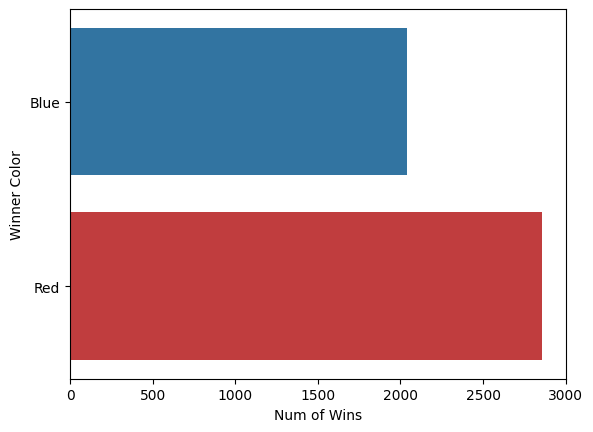

In [11]:
# Visualize # of wins for each color
palette = {
    'Red': 'tab:red',
    'Blue': 'tab:blue'
}
sns.countplot(data=ufc_0.sort_values(by='Winner') , y = 'Winner', palette=palette)
plt.xlabel('Num of Wins')
plt.ylabel('Winner Color')
plt.show();

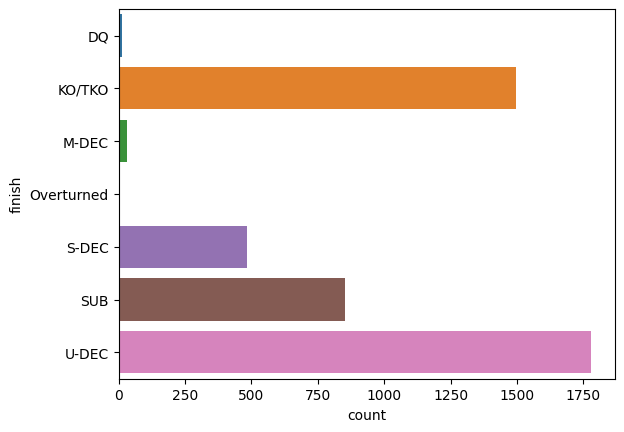

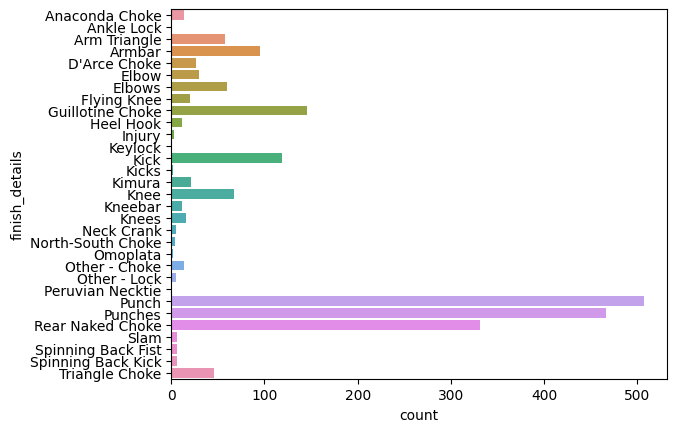

In [12]:
# Visualize the # round finished against the # round planned
sns.countplot(data=ufc_0.sort_values(by='finish') , y = 'finish')
plt.show()

sns.countplot(data=ufc_0.sort_values(by='finish_details') , y = 'finish_details')
plt.show()

In [13]:
# Drop on fight with fighter B reach of 0
ufc_0.drop(ufc_0[ufc_0['B_Reach_cms']==0].index, inplace=True)

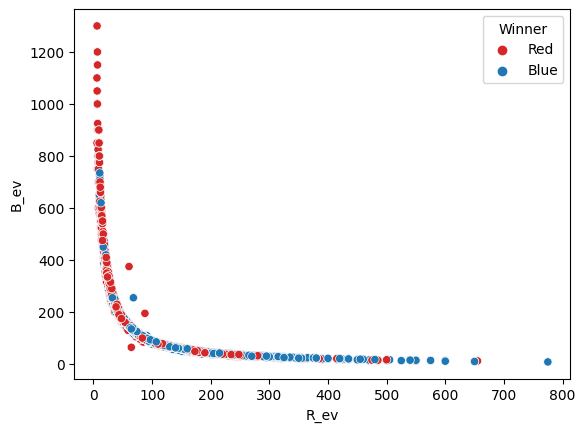

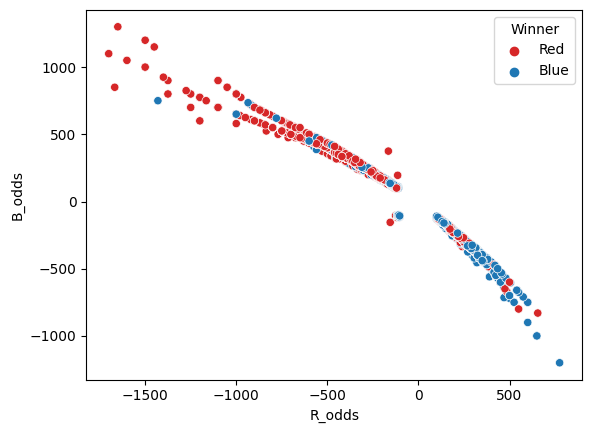

In [14]:
sns.scatterplot(x='R_ev', y='B_ev',hue = 'Winner', palette=palette, data=ufc_0);
plt.show()
sns.scatterplot(x='R_odds', y='B_odds',hue = 'Winner', palette=palette, data=ufc_0);
plt.show()

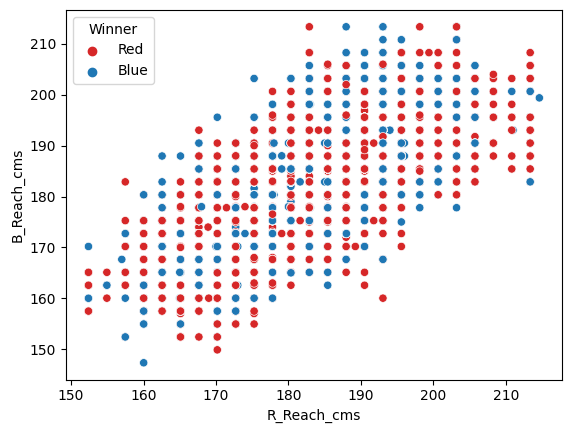

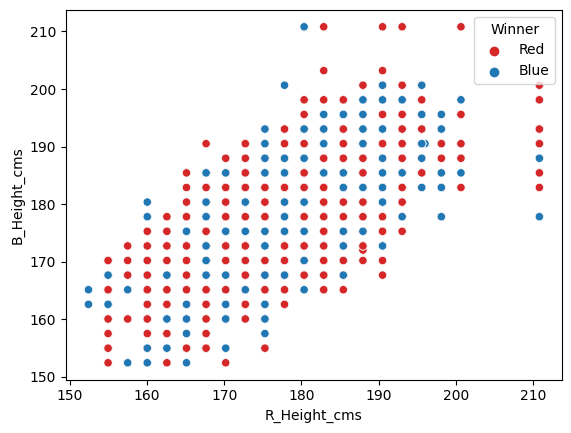

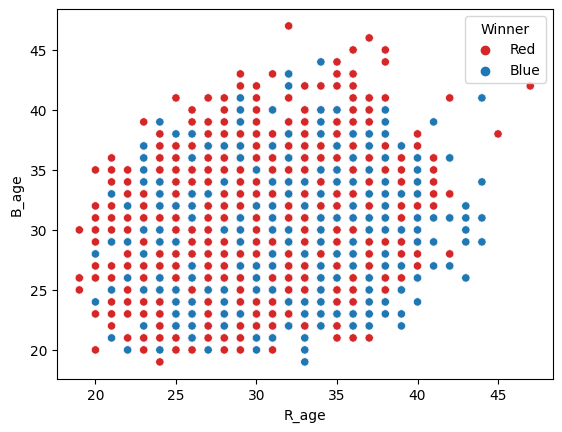

In [15]:
sns.scatterplot(x="R_Reach_cms", y="B_Reach_cms", hue='Winner', palette=palette, data = ufc_0)
plt.show()

sns.scatterplot(x="R_Height_cms", y="B_Height_cms", hue='Winner', palette=palette, data = ufc_0)
plt.show()

sns.scatterplot(x="R_age", y="B_age", hue='Winner',palette=palette, data = ufc_0);
plt.show()

## Feature Engineering

In [16]:
ufc = ufc_0.copy()

In [17]:
# Drop unnecessary information
col = [
    'date','country','location','weight_class','gender','constant_1','finish',
    'finish_details','finish_round','finish_round_time','total_fight_time_secs'   
]
ufc.drop(col, axis=1, inplace=True)

In [18]:
# Combine seperate data
ufc['odds_dif'] = ufc['R_odds']-ufc['B_odds']
ufc['ev_dif'] = ufc['R_ev']-ufc['B_ev']
ufc['current_lose_streak_dif'] = ufc['R_current_lose_streak']-ufc['B_current_lose_streak']
ufc['current_win_streak_dif' ] = ufc['R_current_win_streak']-ufc['B_current_win_streak']
ufc['draw_dif'] = ufc['R_draw']-ufc['B_draw']
ufc['avg_SIG_STR_landed_dif'] = ufc['R_avg_SIG_STR_landed']-ufc['B_avg_SIG_STR_landed']
ufc['avg_SIG_STR_pct_dif'] = ufc['R_avg_SIG_STR_pct']-ufc['B_avg_SIG_STR_pct']
ufc['avg_SUB_ATT_dif'] = ufc['R_avg_SUB_ATT']-ufc['B_avg_SUB_ATT']
ufc['avg_TD_landed_dif'] = ufc['R_avg_TD_landed']-ufc['B_avg_TD_landed']
ufc['avg_TD_pct_dif'] = ufc['R_avg_TD_pct']-ufc['B_avg_TD_pct']
ufc['longest_win_streak_dif' ] = ufc['R_longest_win_streak']-ufc['B_longest_win_streak']
ufc['losses_dif'] = ufc['R_losses']-ufc['B_losses']
ufc['total_rounds_fought_dif'] = ufc['R_total_rounds_fought']-ufc['B_total_rounds_fought']
ufc['total_title_bouts_dif'] = ufc['R_total_title_bouts']-ufc['B_total_title_bouts']
ufc['win_by_Decision_Majority_dif'] = ufc['R_win_by_Decision_Majority']-ufc['B_win_by_Decision_Majority']
ufc['win_by_Decision_Split_dif'] = ufc['R_win_by_Decision_Split']-ufc['B_win_by_Decision_Split']
ufc['win_by_Decision_Unanimous_dif'] = ufc['R_win_by_Decision_Unanimous']-ufc['B_win_by_Decision_Unanimous']
ufc['Win_by_KO/TKO_dif'] = ufc['R_win_by_KO/TKO'] - ufc['B_win_by_KO/TKO']
ufc['win_by_Submission_dif'] = ufc['R_win_by_Submission'] - ufc['B_win_by_Submission']
ufc['win_by_TKO_Doctor_Stoppage_dif'] = ufc['R_win_by_TKO_Doctor_Stoppage'] - ufc['B_win_by_TKO_Doctor_Stoppage']
ufc['wins_dif'] = ufc['R_wins'] - ufc['B_wins']
ufc['Height_cms_dif'] = ufc['R_Height_cms'] - ufc['B_Height_cms']
ufc['Reach_cms_dif'] = ufc['R_Reach_cms'] - ufc['B_Reach_cms']
ufc['Weight_lbs_dif'] = ufc['R_Weight_lbs'] - ufc['B_Weight_lbs']
ufc['age_dif'] = ufc['R_age'] - ufc['B_age']
ufc['dec_odds_dif'] = ufc['r_dec_odds'] - ufc['b_dec_odds']
ufc['sub_odds_dif'] = ufc['r_sub_odds'] - ufc['b_sub_odds']
ufc['ko_odds_dif'] = ufc['r_ko_odds'] - ufc['b_ko_odds']

In [19]:
col2 = [
    'R_odds','B_odds','R_ev','B_ev','R_current_lose_streak','B_current_lose_streak',
    'R_current_win_streak', 'B_current_win_streak', 'R_draw', 'B_draw',
    'R_avg_SIG_STR_landed','B_avg_SIG_STR_landed','R_avg_SIG_STR_pct','B_avg_SIG_STR_pct',
    'R_avg_SUB_ATT', 'B_avg_SUB_ATT', 'R_avg_TD_landed','B_avg_TD_landed',
    'R_avg_TD_pct', 'B_avg_TD_pct', 'R_longest_win_streak', 'B_longest_win_streak',
    'R_losses', 'B_losses', 'R_total_rounds_fought', 'B_total_rounds_fought',
    'R_total_title_bouts', 'B_total_title_bouts',
    'R_win_by_Decision_Majority','B_win_by_Decision_Majority',
    'R_win_by_Decision_Split', 'B_win_by_Decision_Split',
    'R_win_by_Decision_Unanimous', 'B_win_by_Decision_Unanimous',
    'R_win_by_KO/TKO', 'B_win_by_KO/TKO', 'R_win_by_Submission', 'B_win_by_Submission',
    'R_win_by_TKO_Doctor_Stoppage', 'B_win_by_TKO_Doctor_Stoppage', 'R_wins','B_wins',
    'R_Height_cms', 'B_Height_cms', 'R_Reach_cms', 'B_Reach_cms', 'R_Weight_lbs', 'B_Weight_lbs',
    'r_dec_odds','b_dec_odds', 'r_sub_odds', 'b_sub_odds','r_ko_odds','b_ko_odds', 
    'R_age','B_age'
]
ufc.drop(col2, axis=1, inplace=True)

In [20]:
# Most of the ranking will have missing data bc not everyone will be on ranking
ufc['R_match_weightclass_rank'].isnull().sum()

3567

In [21]:
col3 = [
 'B_match_weightclass_rank',
 'R_match_weightclass_rank',
 "R_Women's Flyweight_rank",
 "R_Women's Featherweight_rank",
 "R_Women's Strawweight_rank",
 "R_Women's Bantamweight_rank",
 'R_Heavyweight_rank',
 'R_Light Heavyweight_rank',
 'R_Middleweight_rank',
 'R_Welterweight_rank',
 'R_Lightweight_rank',
 'R_Featherweight_rank',
 'R_Bantamweight_rank',
 'R_Flyweight_rank',
 'R_Pound-for-Pound_rank',
 "B_Women's Flyweight_rank",
 "B_Women's Featherweight_rank",
 "B_Women's Strawweight_rank",
 "B_Women's Bantamweight_rank",
 'B_Heavyweight_rank',
 'B_Light Heavyweight_rank',
 'B_Middleweight_rank',
 'B_Welterweight_rank',
 'B_Lightweight_rank',
 'B_Featherweight_rank',
 'B_Bantamweight_rank',
 'B_Flyweight_rank',
 'B_Pound-for-Pound_rank',
]
ufc.drop(col3, axis=1, inplace=True)

In [22]:
ufc_0.describe()

,R_odds,B_odds,R_ev,B_ev,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,...,B_Flyweight_rank,B_Pound-for-Pound_rank,finish_round,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
count,4894.000000,4895.000000,4894.000000,4895.000000,4895.000000,4895.000000,4895.000000,4895.000000,3965.000000,4130.000000,...,95.000000,35.000000,4273.000000,4273.000000,4092.000000,4076.000000,3846.000000,3834.000000,3846.000000,3833.000000
mean,-117.578668,65.975689,94.841908,167.049019,3.182022,0.477835,0.875587,0.010623,26.314616,0.444761,...,8.473684,9.485714,2.407910,652.255792,294.096285,416.449951,843.014821,1064.589984,514.338274,647.201670
std,268.874177,247.799413,82.845652,136.937594,0.571568,0.769428,1.311453,0.108344,20.935043,0.121340,...,4.259763,4.300283,0.996719,357.933247,230.603308,306.550051,550.198218,627.360151,413.623890,458.893637
min,-1700.000000,-1200.000000,5.882353,8.333333,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,5.000000,-440.000000,-200.000000,-370.000000,-1250.000000,-550.000000,-275.000000
25%,-255.000000,-145.000000,39.215686,68.965517,3.000000,0.000000,0.000000,0.000000,5.640000,0.387500,...,5.000000,5.000000,1.000000,297.000000,167.750000,224.750000,435.000000,590.000000,240.000000,325.000000
50%,-150.000000,130.000000,66.666667,130.000000,3.000000,0.000000,0.000000,0.000000,24.769231,0.450000,...,8.000000,10.000000,3.000000,900.000000,250.000000,349.000000,720.000000,976.000000,435.000000,547.000000
75%,126.750000,220.000000,126.750000,220.000000,3.000000,1.000000,1.000000,0.000000,39.100000,0.510000,...,12.000000,13.500000,3.000000,900.000000,400.000000,525.000000,1200.000000,1400.000000,700.000000,881.000000
max,775.000000,1300.000000,775.000000,1300.000000,5.000000,6.000000,12.000000,2.000000,154.000000,1.000000,...,15.000000,15.000000,5.000000,1500.000000,2200.000000,2600.000000,4665.000000,4785.000000,2675.000000,3200.000000


In [23]:
col = ufc.columns
num_col = ufc._get_numeric_data().columns
a = list(set(col) - set(num_col))
a

['R_Stance', 'B_fighter', 'better_rank', 'B_Stance', 'R_fighter', 'Winner']

In [24]:
# Convert categorical data to numerical
label = LabelEncoder()
for i in a:
    ufc[i] = label.fit_transform(ufc[i])

In [25]:
# Convert Boolen to int
ufc['title_bout'] = [1 if bout == True else 0 for bout in ufc.title_bout]

In [26]:
ufc_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4895 entries, 0 to 4895
Columns: 119 entries, R_fighter to b_ko_odds
dtypes: bool(1), float64(58), int64(46), object(14)
memory usage: 4.4+ MB


In [27]:
ufc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4895 entries, 0 to 4895
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   R_fighter                       4895 non-null   int64  
 1   B_fighter                       4895 non-null   int64  
 2   Winner                          4895 non-null   int64  
 3   title_bout                      4895 non-null   int64  
 4   no_of_rounds                    4895 non-null   int64  
 5   B_Stance                        4895 non-null   int64  
 6   R_Stance                        4895 non-null   int64  
 7   lose_streak_dif                 4895 non-null   int64  
 8   win_streak_dif                  4895 non-null   int64  
 9   longest_win_streak_dif          4895 non-null   int64  
 10  win_dif                         4895 non-null   int64  
 11  loss_dif                        4895 non-null   int64  
 12  total_round_dif                 48

In [28]:
ufc.head()

,R_fighter,B_fighter,Winner,title_bout,no_of_rounds,B_Stance,R_Stance,lose_streak_dif,win_streak_dif,longest_win_streak_dif,...,Win_by_KO/TKO_dif,win_by_Submission_dif,win_by_TKO_Doctor_Stoppage_dif,wins_dif,Height_cms_dif,Reach_cms_dif,Weight_lbs_dif,dec_odds_dif,sub_odds_dif,ko_odds_dif
0,1233,746,1,0,5,1,1,-3,1,0,...,7,0,0,8,-10.16,-15.24,0,-100.0,400.0,-285.0
1,42,1158,0,0,3,1,1,0,0,2,...,0,1,0,5,-2.54,0.00,0,100.0,-400.0,430.0
2,940,876,0,0,3,2,1,0,0,-1,...,0,5,0,-3,5.08,0.00,20,275.0,-1125.0,415.0
3,48,1077,1,0,3,1,1,0,0,2,...,2,0,0,4,-2.54,5.08,0,-725.0,-3000.0,-990.0
4,615,645,0,0,3,1,1,0,-2,2,...,-1,2,0,-1,0.00,5.08,10,-35.0,-800.0,300.0


## Data Cleaning

In [29]:
ufc.isnull().sum()

R_fighter                            0
B_fighter                            0
Winner                               0
title_bout                           0
no_of_rounds                         0
B_Stance                             0
R_Stance                             0
lose_streak_dif                      0
win_streak_dif                       0
longest_win_streak_dif               0
win_dif                              0
loss_dif                             0
total_round_dif                      0
total_title_bout_dif                 0
ko_dif                               0
sub_dif                              0
height_dif                           0
reach_dif                            0
age_dif                              0
sig_str_dif                          0
avg_sub_att_dif                      0
avg_td_dif                           0
empty_arena                          0
better_rank                          0
odds_dif                             1
ev_dif                   

In [30]:
ufc.fillna(0, axis=1, inplace=True)
ufc.isnull().sum()

R_fighter                         0
B_fighter                         0
Winner                            0
title_bout                        0
no_of_rounds                      0
B_Stance                          0
R_Stance                          0
lose_streak_dif                   0
win_streak_dif                    0
longest_win_streak_dif            0
win_dif                           0
loss_dif                          0
total_round_dif                   0
total_title_bout_dif              0
ko_dif                            0
sub_dif                           0
height_dif                        0
reach_dif                         0
age_dif                           0
sig_str_dif                       0
avg_sub_att_dif                   0
avg_td_dif                        0
empty_arena                       0
better_rank                       0
odds_dif                          0
ev_dif                            0
current_lose_streak_dif           0
current_win_streak_dif      

# Initial Model Training

## Baseline Model

In [31]:
seed = 7406

In [32]:
Y = ufc.Winner
X = ufc.copy()
X.drop(['Winner'], axis=1, inplace=True)

X_train, X_val, Y_train, Y_val = train_test_split(X, 
                                                  Y, 
                                                  test_size = 0.3, 
                                                  random_state=seed)
X_train.shape

(3426, 49)

In [33]:
m0 = RandomForestClassifier(random_state=seed)
m0.fit(X_train, Y_train)

acc0 = accuracy_score(Y_val, m0.predict(X_val))
print(acc0)

0.6446562287270252


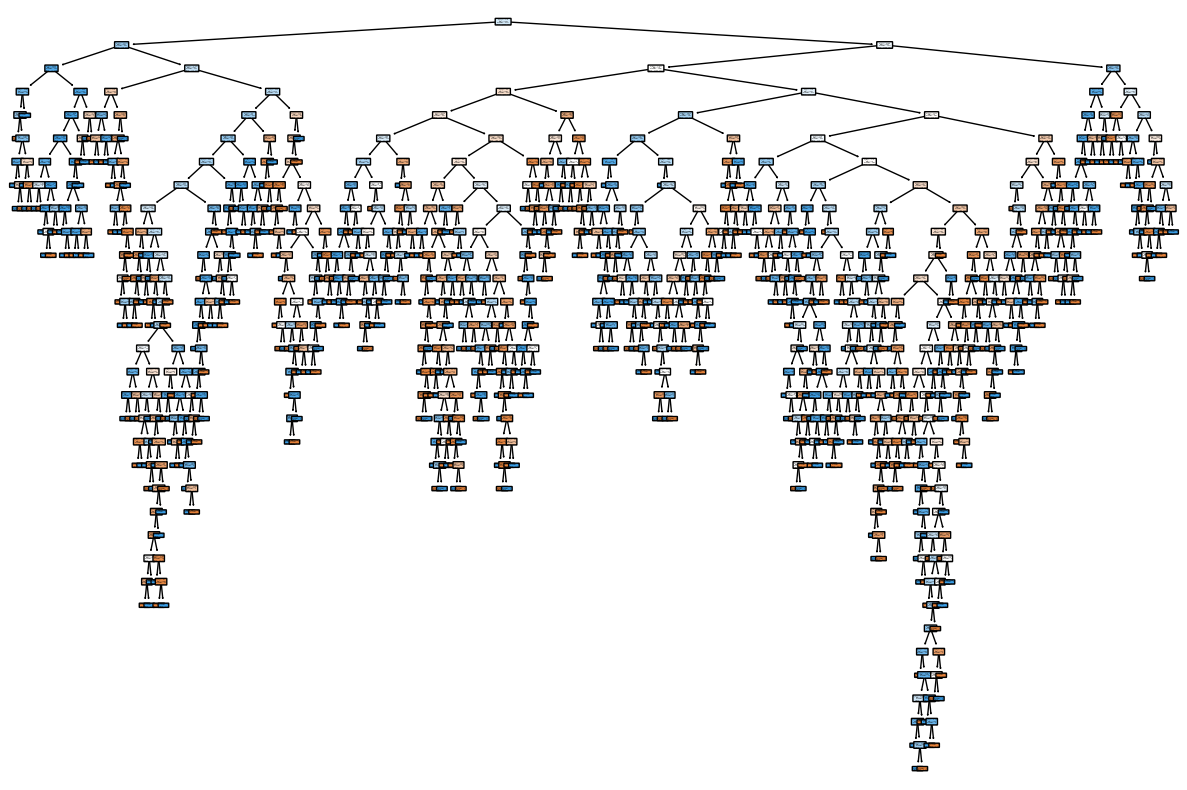

In [34]:
# Extract single tree and display it
fig = plt.figure(figsize=(15, 10))
plot_tree(m0.estimators_[0],  
          filled=True, impurity=True, 
          rounded=True)
plt.show()

### Other Models

In [35]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Logistic Regression
m0_1 = LogisticRegression(random_state=seed)
m0_1.fit(X_train, Y_train)
acc0_1 = accuracy_score(Y_val, m0_1.predict(X_val))
print(f'Logistric Regression: {acc0_1}')

# LDA
m0_2 = LDA()
m0_2.fit(X_train, Y_train)
acc0_2 = accuracy_score(Y_val, m0_2.predict(X_val))
print(f'LDA: {acc0_2}')

# Ridge
m0_3 = RidgeClassifier()
m0_3.fit(X_train, Y_train)
acc0_3 = accuracy_score(Y_val, m0_3.predict(X_val))
print(f'Ridge: {acc0_3}')

# Boost
m0_4 = XGBClassifier()
m0_4.fit(X_train, Y_train)
acc0_4 = accuracy_score(Y_val, m0_4.predict(X_val))
print(f'Boost: {acc0_4}')

Logistric Regression: 0.6671204901293397
LDA: 0.6609938733832539
Ridge: 0.6623553437712729
Boost: 0.627637848876787


# Model Tuning

## Data Scaling

In [36]:
X_s = X.copy()

# Scale X data
scaler = StandardScaler()
X_s = pd.DataFrame(scaler.fit_transform(X_s))
X_s.head()

X_s_train, X_s_val, Y_train, Y_val = train_test_split(X_s, 
                                                          Y, 
                                                          test_size = 0.3, 
                                                          random_state=seed)

print(X_s_train.shape)
X_s_train.head(3)

(3426, 49)


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
4501,0.561742,0.244827,-0.225066,-0.318494,1.262820,1.362953,0.900156,0.101130,1.101216,-0.890113,...,0.251658,-0.157812,-0.062217,0.890113,0.799573,0.287394,-0.047339,0.294951,0.201811,0.169881
601,-1.360704,0.866100,-0.225066,-0.318494,-0.533085,-0.527034,-0.105840,0.101130,0.608397,-0.642000,...,0.251658,-0.157812,-0.062217,0.642000,-0.781876,-0.627185,-0.047339,0.531634,1.630339,0.837572
4667,0.494650,-0.553337,-0.225066,-0.318494,-0.533085,-0.527034,-1.111837,-1.055489,0.115578,0.102337,...,-0.240498,0.410614,-0.062217,-0.102337,-1.967963,-1.236904,1.003569,0.294951,0.201811,0.169881


In [37]:
m1 = RandomForestClassifier(random_state=seed)
m1.fit(X_s_train, Y_train)

acc1 = accuracy_score(Y_val, m1.predict(X_s_val))
print(acc1)

0.6446562287270252


### Other Models

In [38]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Logistic Regression
m1_1 = LogisticRegression(random_state=seed)
m1_1.fit(X_s_train, Y_train)
acc1_1 = accuracy_score(Y_val, m1_1.predict(X_s_val))
print(f'Logistric Regression: {acc1_1}')

# LDA
m1_2 = LDA()
m1_2.fit(X_s_train, Y_train)
acc1_2 = accuracy_score(Y_val, m1_2.predict(X_s_val))
print(f'LDA: {acc1_2}')

# Ridge
m1_3 = RidgeClassifier()
m1_3.fit(X_s_train, Y_train)
acc1_3 = accuracy_score(Y_val, m1_3.predict(X_s_val))
print(f'Ridge: {acc1_3}')

# Boost
m1_4 = XGBClassifier()
m1_4.fit(X_s_train, Y_train)
acc1_4 = accuracy_score(Y_val, m1_4.predict(X_s_val))
print(f'Boost: {acc1_4}')

Logistric Regression: 0.6664397549353301
LDA: 0.6609938733832539
Ridge: 0.6637168141592921
Boost: 0.627637848876787


## Manual Feature Selection

In [39]:
corr_winner = ufc.corr()['Winner']
corr_winner[abs(corr_winner) > 0.2]

Winner          1.000000
odds_dif       -0.334123
ev_dif         -0.338840
dec_odds_dif   -0.255036
ko_odds_dif    -0.213989
Name: Winner, dtype: float64

In [40]:
X_new = X.copy()

# Drop predictors w/ corr more than 0.2
col4 = ['odds_dif', 'ev_dif', 'dec_odds_dif', 'ko_odds_dif']
X_new.drop(col4, axis=1, inplace=True)
X_new.head(3)

# Replace Stances
X_new['Stance_dif'] = X_new['R_Stance']-X_new['B_Stance']
X_new.drop(['R_Stance','B_Stance'], axis=1,inplace=True)

X_new_train, X_new_val, Y_train, Y_val = train_test_split(X_new, 
                                                          Y, 
                                                          test_size = 0.3, 
                                                          random_state=seed)
print(X_new_train.shape)
X_new_train.head()

(3426, 44)


,R_fighter,B_fighter,title_bout,no_of_rounds,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,...,win_by_Decision_Unanimous_dif,Win_by_KO/TKO_dif,win_by_Submission_dif,win_by_TKO_Doctor_Stoppage_dif,wins_dif,Height_cms_dif,Reach_cms_dif,Weight_lbs_dif,sub_odds_dif,Stance_dif
4502,886.0,892.0,0.0,3.0,1.0,0.0,3.0,-5.0,2.0,-20.0,...,3.0,1.0,0.0,0.0,5.0,5.08,2.54,0.0,0.0,0.0
601,141.0,1180.0,0.0,3.0,0.0,0.0,2.0,-4.0,-2.0,-19.0,...,1.0,1.0,0.0,0.0,4.0,-5.08,-5.08,0.0,1200.0,0.0
4668,860.0,522.0,0.0,3.0,-1.0,-2.0,1.0,-1.0,-2.0,3.0,...,1.0,0.0,1.0,0.0,1.0,-12.70,-10.16,10.0,0.0,0.0
1383,324.0,447.0,0.0,3.0,0.0,-2.0,2.0,-2.0,4.0,-11.0,...,0.0,2.0,0.0,0.0,2.0,-5.08,-0.04,0.0,550.0,0.0
4543,361.0,1513.0,1.0,5.0,0.0,1.0,-1.0,1.0,0.0,3.0,...,-1.0,0.0,0.0,0.0,-1.0,5.08,2.54,0.0,0.0,0.0


In [41]:
m2 = RandomForestClassifier(random_state=seed)
m2.fit(X_new_train, Y_train)

acc2 = accuracy_score(Y_val, m2.predict(X_new_val))
print(acc2)

0.6113002042205582


### Other Models

In [42]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Logistic Regression
m2_1 = LogisticRegression(random_state=seed)
m2_1.fit(X_new_train, Y_train)
acc2_1 = accuracy_score(Y_val, m2_1.predict(X_new_val))
print(f'Logistric Regression: {acc2_1}')

# LDA
m2_2 = LDA()
m2_2.fit(X_new_train, Y_train)
acc2_2 = accuracy_score(Y_val, m2_2.predict(X_new_val))
print(f'LDA: {acc2_2}')

# Ridge
m2_3 = RidgeClassifier()
m2_3.fit(X_new_train, Y_train)
acc2_3 = accuracy_score(Y_val, m2_3.predict(X_new_val))
print(f'Ridge: {acc2_3}')

# Boost
m2_4 = XGBClassifier()
m2_4.fit(X_new_train, Y_train)
acc2_4 = accuracy_score(Y_val, m2_4.predict(X_new_val))
print(f'Boost: {acc2_4}')

Logistric Regression: 0.6296800544588155
LDA: 0.6351259360108917
Ridge: 0.6330837304288631
Boost: 0.5867937372362151


## Automatic Feature Selection

In [43]:
model = SelectFromModel(m1, prefit=True)
X_s_new = pd.DataFrame(model.transform(X_s))
X_s_new.head()

X_s_new_train, X_s_new_val, Y_train, Y_val = train_test_split(X_s_new, 
                                                          Y, 
                                                          test_size = 0.3, 
                                                          random_state=seed)
print(X_s_new_train.shape)

(3426, 20)


In [44]:
m3 = RandomForestClassifier(random_state=seed)
m3.fit(X_s_new_train, Y_train)

acc3 = accuracy_score(Y_val, m3.predict(X_s_new_val))
print(acc3)

0.6371681415929203


### Other Models

In [45]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Logistic Regression
m3_1 = LogisticRegression(random_state=seed)
m3_1.fit(X_s_new_train, Y_train)
acc3_1 = accuracy_score(Y_val, m3_1.predict(X_s_new_val))
print(f'Logistric Regression: {acc3_1}')

# LDA
m3_2 = LDA()
m3_2.fit(X_s_new_train, Y_train)
acc3_2 = accuracy_score(Y_val, m3_2.predict(X_s_new_val))
print(f'LDA: {acc3_2}')

# Ridge
m3_3 = RidgeClassifier()
m3_3.fit(X_s_new_train, Y_train)
acc3_3 = accuracy_score(Y_val, m3_3.predict(X_s_new_val))
print(f'Ridge: {acc3_3}')

# Boost
m3_4 = XGBClassifier()
m3_4.fit(X_s_new_train, Y_train)
acc3_4 = accuracy_score(Y_val, m3_4.predict(X_s_new_val))
print(f'Boost: {acc3_4}')

Logistric Regression: 0.6603131381892444
LDA: 0.6596324029952348
Ridge: 0.6603131381892444
Boost: 0.628999319264806


## Cross Validation

In [46]:
# Mean TE for 100 5-fold CV
acc4 = np.mean(cv_score(m0, X, Y, cv=100))
print(acc4)

0.6283630952380953


### Other Models

In [48]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Logistic Regression
acc4_1 = np.mean(cv_score(m0_1, X, Y, cv=100))
print(f'Logistric Regression: {acc4_1}')

# LDA
acc4_2 = np.mean(cv_score(m0_2, X, Y, cv=100))
print(f'LDA: {acc4_2}')

# Ridge
acc4_3 = np.mean(cv_score(m0_3, X, Y, cv=100))
print(f'Ridge: {acc4_3}')

# Boost
acc4_4 = np.mean(cv_score(m0_4, X, Y, cv=100))
print(f'Boost: {acc3_4}')

Logistric Regression: 0.6532950680272108
LDA: 0.6496471088435375
Ridge: 0.6504591836734694
Boost: 0.628999319264806
